***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6. Introduction](6_0_introduction.ipynb)  
    * Next: [6.2 Interative Deconvolution with Point Sources (CLEAN)](6_2_clean.ipynb)

***

Import standard modules:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [ ]:
import matplotlib.image as mpimg
from IPython.display import Image
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [ ]:
from IPython.display import HTML
HTML('../style/code_toggle.html')

***

## 6.1 Sky Models<a id='deconv:sec:skymodels'></a>

Before we dive into deconvolution methods we need to introduce the concept of a *sky model*. Since we are making an incomplete sampling of the visibilities with limited resolution we do not recover the 'true' sky from an observation. The dirty image is the 'true' sky convolved (effectively blurred) out by the array point spread function (PSF). As discussed in the previous chapter, the PSF acts as a type of low-pass spatial filter limiting our resolution of the sky. We would like to some how recover a model for the true sky. At the end of deconvolution one of the outputs is the sky model.

We can look at the deconvolution process backwards by taking an ideal sky, shown in the left figure below (it may be difficult to see but there are various pixels with different intensities), and convolving it with the PSF response of the KAT-7 array, shown on the right, this is a point-source based sky model which will be discussed below. The sky model looks like a mostly empty image with a few non-zero pixels. The PSF is the same as the one shown in the previous chapter.

In [ ]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-model.fits', \
                       figure=fig, subplot=[0.0,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-0.1, vmax=1.0, cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Sky Model')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-psf.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('KAT-7 PSF')
gc2.add_colorbar()

fig.canvas.draw()

*Left: a point-source sky model of a field of sources with various intensities. Right: PSF response of KAT-7 for a 6 hour observation at a declination of $-30^{\circ}$.*

By convolving the ideal sky with the array PSF we effectively are recreating the dirty image. The figure on the left below shows the sky model convolved with the KAT-7 PSF. The centre image is the original dirty image created using uniform weighting in the previous chapter. The figure on the right is the difference between the two figures. The negative offset is an effect of the imager producing an absolute value PSF image. The main point to note is that the difference image shows the bright sources removed resulting in a fairly noise-like image. 

In [ ]:
fig = plt.figure(figsize=(16, 5))

fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-model.fits')
skyModel = fh[0].data
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-psf.fits')
psf = fh[0].data
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits')
dirtyImg = fh[0].data
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits')
residualImg = fh[0].data

#convolve the sky model with the PSF
sampFunc = np.fft.fft2(psf) #sampling function
skyModelVis = np.fft.fft2(skyModel) #sky model visibilities
sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
convImg = np.fft.fftshift(np.fft.ifft2(sampModelVis)).real + residualImg #sky model convolved with PSF

gc1 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0,0.0,0.30,1])
gc1.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('PSF convolved with Sky Model')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure(dirtyImg, figure=fig, subplot=[0.33,0.0,0.30,1])
gc2.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Dirty')
gc2.add_colorbar()

gc3 = aplpy.FITSFigure(dirtyImg - convImg, figure=fig, subplot=[0.67,0.0,0.30,1])
gc3.show_colorscale(cmap='viridis')
gc3.hide_axis_labels()
gc3.hide_tick_labels()
plt.title('Difference')
gc3.add_colorbar()

fig.canvas.draw()

*Left: the point-source sky model convolved with the KAT-7 PSF with the residual image added. Centre: the original dirty image. Right: the difference between the PSF-convoled sky model and the dirty image.*

Now that we see we can recreate the dirty image from a sky model and the array PSF, we just need to learn how to do the opposite operation, deconvolution. In order to simplify the process we incorporate knowledge about the sky, primarily by assuming a simple model for the sources.

### 6.1.1 The Point Source Assumption

We can use some prior information about the sources in the sky and the array as *a priori* information in our deconvolution attempt. The array and observation configuration results in a PSF which has a primary lobe of a particular scale, this is the effective resolution of the array. As we have seen in [$\S$ 5.4 &#10142;](../5_Imaging/5_4_imaging_weights.ipynb) the choice of weighting functions can result in different PSF resolutions. But, no matter the array there is a limit to the resolution, so any source which has a smaller angular scale than the PSF resolution appears to be a *point source*. A point source is an idealized source which has no angular scale and is represented by a spatial Dirac $\delta$-function. Though all sources in the sky have a angular scale, many are much smaller than the angular resolution of the array PSF, so they can be approximated as a simple point source.

A nice feature of the point source model is that the Fourier transform of a Dirac $\delta$-function, by the Fourier shift theorem, is a simple complex phase function and the constant flux

$$
\mathscr{F} \{ C(\nu) \cdot \delta\,(l- l_0, m - m_0)\}(u, v) = C(\nu) \cdot\iint \limits_{-\infty}^{\infty} \delta\,(l- l_0, m - m_0) \, e^{-2 \pi i (ul + vm)}\,dl\,dm = C(\nu) \cdot e^{-2 \pi i (ul_0 + vm_0)} \quad (6.1.1)
$$

where $C(\nu)$ is the flux of the source (which can include a dependence on observing frequency $\nu$), and $(l_0, m_0)$ is the phase centre. At the phase centre $(l_0, m_0)$, $\mathscr{F} \{ C \cdot \delta\,(0, 0)\} = C$. A $\delta$-function based sky model leads to a nice, and computationally fast, method to generate visibilities, which is useful for deconvolution methods as we will see later in this chapter.

Of course we need to consider if using a collection of $\delta$-functions for a sky model is actually a good idea. The short answer is 'yes', the long answer 'yes to a limit' and current research is focused on using more advanced techniques to improve deconvolution. This is because the 2D Dirac $\delta$-function can be used as a complete orthogonal basis set to describe any 2D function. Most sources in the sky are *unresolved*, that is they have a much smaller angular resolution then that of the array PSF. Sky sources which are *resolved* are a bit trickier, we will consider these sources later in the section. 

A $\delta$-function basis set is also good for astronomical images because these images are generally *sparse*. That is, out of the thousands or millions of pixels in the image, only a few of the pixels contain sky sources (i.e. these pixels contain the information we desire) above the observed noise floor, the rest of the pixels contain mostly noise (i.e. contain no information). This differs from a natural image, for example a photograph of a duck, which is simply a collection of $\delta$-functions with different constant scale factors, one for each pixel in the image. Every pixel in a natural image generally contains information. We would say that in the $\delta$-function basis set a natural image is not sparse. As a side note, a natural image is usually sparse in wavelet space which is why image compression uses wavelet transforms.

Since an astronomical image is sparse we should be able to reduce the image down to separate out the noise from the sources and produce a small model which represents the true sky, this is the idea behind deconvolution. Looked in a different way, deconvolution is a process of filtering out the true sky flux from the instrument induced noise in each pixel. This idea of sparseness and information in aperture synthesis images is related to the field of compressed sensing. Much of the current research in radio interferometric deconvolution is framed in the compressed sensing context.
 
At the end of an deconvolution process we end up with two products: the sky model, and a set of residuals. A sky model can be as simple as a list of positions (either pixel number of sky position) and a flux value (and maybe a spectral index), e.g.

| Source ID | RA (H)      | Dec (deg)    | Flux (Jy) | SPI   |
| --------- | ----------- | ------------ | --------- | ----- |
| 0         | 00:02:18.81 | -29:47:17.82 | 3.55      | -0.73 |
| 1         | 00:01:01.84 | -30:06:27.53 | 2.29      | -0.52 |
| 2         | 00:03:05.54 | -30:00:22.57 | 1.01      | -0.60 |

*Table: A simple sky model of three unpolarized sources with different spectral indicies.*

In this simple sky model there are three sources near right ascension 0 hours and declination $-30^{\circ}$, each source has an unpolarized flux in Jy and a spectral index.

The residuals are generally an image which results from the subtraction of the sky model from the original image. Additionally, a *restored image* is often produced, this is constructed from the sky model and residual image. This will be discussed further in the next few sections. An example of residual and restored images are shown below.

In [ ]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits', \
                       figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-0.8, vmax=3., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Residual')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-image.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-0.8, vmax=3., cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Restored')
gc2.add_colorbar()

fig.canvas.draw()

*Left: residual image after running a CLEAN deconvolution. Right: restored image constructed from convolving the point-source sky model with an 'ideal' PSF and adding the residual image.*

Deconvolution, as can be seen in the figure on the left, builds a sky model by subtracts sources from the dirty image and adding them to a sky model. The resulting image shows the residual flux which was not added to the sky model. The restored image is a reconstruction of the field by convolving the sky model with an 'ideal' PSF and adding the residual image. This process will be discussed in the sections that follow.

The assumption that most sources are point source-like or can be represented by a set of point sources is the basis for the standard deconvolution process in radio interferometry, `CLEAN`. Though there are many new methods to perform deconvolution, `CLEAN` is the standard method and continues to dominate the field.

### 6.1.2 Resolved Sources

We need to consider what it means for a source to be 'resolved'. Each baseline in an array measures a particular spatial resolution. If the angular scale of a source is smaller than the spatial resolution of the longest baseline then the source is unresolved on every baseline. If the angular scale of a source is larger than the shortest baseline spatial resolution then the source is resolved on all baselines. In between these two extremes a source is resolved on longer baselines and unresolved on shorter baselines, thus the source is said to be *partially resolved*. The term *extended source* is often used as a synonym for fully- and partially-resolved sources.

Simple Gaussian extended sources are shown in the figure below. All sources have been normalized to have the same integrated flux. On the left is a very extended source, moving right, the source becomes progressively smaller, until the right most source which is a nearly point-source like object. Transforming each source into the visibility space, via Fourier transform, we plot the flux of each source as a function of baseline length. Baseline direction does not matter in these simple examples because the sources are circular Gaussians. For a very extended source (blue) the flux drops off quickly as a function of baseline length. In the limit the Gaussian size is decreased to that of a delta function the flux distribution (dashed black) is flat across all baseline lengths (this is the ideal case).

[]

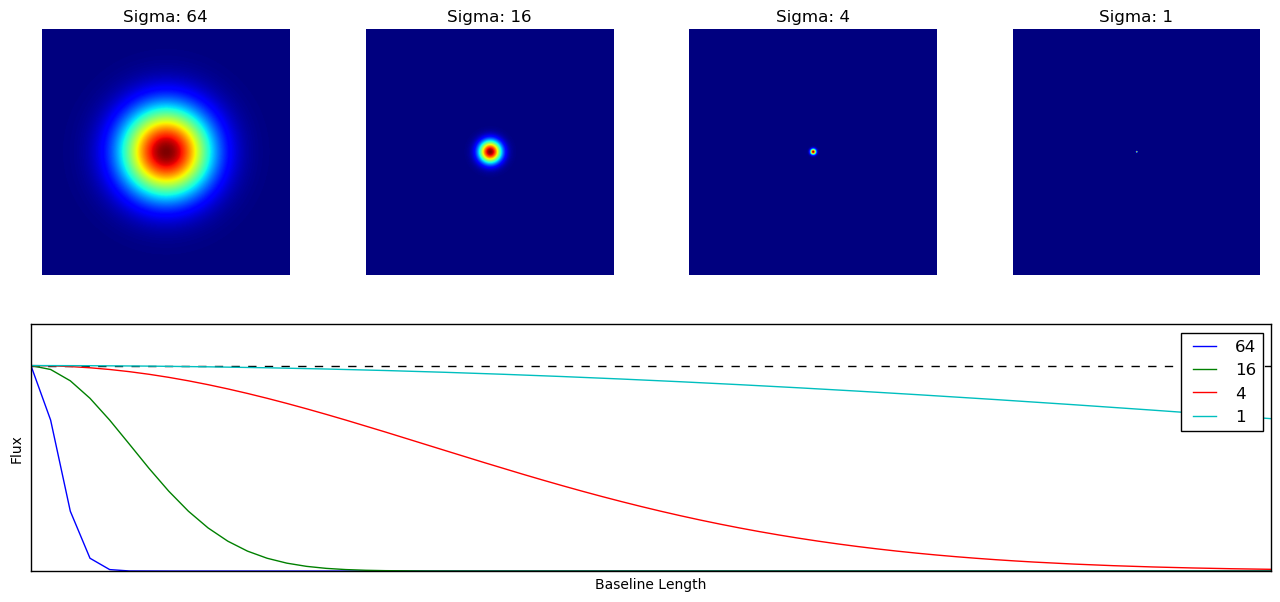

In [8]:
def gauss2d(sigma):
    """Return a normalized 2d Gaussian function, sigma: size in pixels"""
    return lambda x,y: (1./(2.*np.pi*(sigma**2.))) * np.exp(-1. * ((xpos**2. + ypos**2.) / (2. * sigma**2.)))

imgSize = 512
xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float)
xpos -= imgSize/2.
ypos -= imgSize/2.
sigmas = [64., 16., 4., 1.]

fig = plt.figure(figsize=(16, 7))

#Gaussian image-domain source
ax1 = plt.subplot2grid((2, 4), (0, 0))
gauss1 = gauss2d(sigmas[0])
ax1.imshow(gauss1(xpos, ypos))
ax1.axis('off')
plt.title('Sigma: %i'%int(sigmas[0]))

#Gaussian image-domain source
ax2 = plt.subplot2grid((2, 4), (0, 1))
gauss2 = gauss2d(sigmas[1])
ax2.imshow(gauss2(xpos, ypos))
ax2.axis('off')
plt.title('Sigma: %i'%int(sigmas[1]))

#Gaussian image-domain source
ax3 = plt.subplot2grid((2, 4), (0, 2))
gauss3 = gauss2d(sigmas[2])
ax3.imshow(gauss3(xpos, ypos))
ax3.axis('off')
plt.title('Sigma: %i'%int(sigmas[2]))
          
#Gaussian image-domain source
ax4 = plt.subplot2grid((2, 4), (0, 3))
gauss4 = gauss2d(sigmas[3])
ax4.imshow(gauss4(xpos, ypos))
ax4.axis('off')
plt.title('Sigma: %i'%int(sigmas[3]))

#plot the visibility flux distribution as a function of baseline length
ax5 = plt.subplot2grid((2, 4), (1, 0), colspan=4)
visGauss1 = np.abs( np.fft.fftshift( np.fft.fft2(gauss1(xpos, ypos))))
visGauss2 = np.abs( np.fft.fftshift( np.fft.fft2(gauss2(xpos, ypos))))
visGauss3 = np.abs( np.fft.fftshift( np.fft.fft2(gauss3(xpos, ypos))))
visGauss4 = np.abs( np.fft.fftshift( np.fft.fft2(gauss4(xpos, ypos))))
ax5.plot(visGauss1[int(imgSize/2),int(imgSize/2):], label='%i'%int(sigmas[0]))
ax5.plot(visGauss2[int(imgSize/2),int(imgSize/2):], label='%i'%int(sigmas[1]))
ax5.plot(visGauss3[int(imgSize/2),int(imgSize/2):], label='%i'%int(sigmas[2]))
ax5.plot(visGauss4[int(imgSize/2),int(imgSize/2):], label='%i'%int(sigmas[3]))
ax5.hlines(1., xmin=0, xmax=int(imgSize/2)-1, linestyles='dashed')
plt.legend()
plt.ylabel('Flux')
plt.xlabel('Baseline Length')
plt.xlim(0, int(imgSize/8)-1)
ax5.set_xticks([])
ax5.set_yticks([])

*Top Figures: simple Gaussian extented sources, all sources are normalized to the same integrated flux. Bottom figure: the baseline length-dependent flux distribution in the visibility space for each source (labels indicate relavive width of source compared to the smallest source). The dashed line represents an idealized point source with the same flux as the Gaussian sources.*

The smaller the extended source the better a $\delta$-function is at approximating the source. But, a $\delta$-function does not work well for extended sources. A simple solution is to use a set of point sources to model an extended object. This can work well to an extent, but there is a trade off to be made. Because the $\delta$-function has a flat baseline-dependent response in the visibility domain the curves shown in the plot above can not be modeled with $\delta$-functions, the curves can only be approximated. As the limits of using a $\delta$-function sky model for extended sources is reached new sky models need to be introduced. Though it is beyond the scope of this work there has been siginificant work done on using Gaussian [<cite data-cite='2008ISTSP...2..793C'>[1]</cite> &#10548;](http://arxiv.org/abs/0806.2228) and Shapelet [<cite data-cite='2002ApJ...570..447C'>[2]</cite> &#10548;](http://arxiv.org/abs/astro-ph/0107085) [<cite data-cite='python_shapelets'>[3]</cite> &#10548;](https://github.com/griffinfoster/shapelets) functions to model extended sources.

An additional issue that arises is that an array PSF size varies depending on observing frequency during an observation. An observation is made over a set frequency bandwidth, and the baseline length is measured in number of wavelengths and not metres. We used this to our advantage to fill the *uv*-plane in [$\S$ 5.2 &#10142;](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb). The highest frequency observation will have a better resolution then the lowest frequency observation. In the past this was not an issue because the difference in fractional bandwidth between the top and bottom of the observing band was usually small and the resolution could be approximated as constant across the band. But, modern telescopes have large fractional bandwidths, resulting in significant resolution difference between the lowest and highest frequencies. This leads to issues where, on a single baselines, a source can be resolved at high frequency but is  unresolved at a lower frequency. The issue of imaging and deconvolution with wide bandwidth systems is a topic of active research.

Now that we have justified the use of $\delta$-functions to describe a sky model, even as approximations to extended sources, we are now ready to see how a sky model is constructed from the dirty image via deconvolution.

***

Next: [6.2 Interative Deconvolution with Point Sources (CLEAN)](6_2_clean.ipynb)

<div class=warn><b>Future Additions:</b></div>

* example: extended object, cygnus a?
* example: point source, gaussian, shapelet source models of the same source